In [1]:
import sys
import logging
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import time
from datetime import datetime
from pyproj import Transformer, CRS
from shapely.geometry import Polygon, Point
from sliderule import icesat2

In [2]:
# Configure Logging
icesat2_logger = logging.getLogger("sliderule.icesat2")
icesat2_logger.setLevel(logging.INFO)
# Create Console Output
ch = logging.StreamHandler()
ch.setLevel(logging.INFO)
icesat2_logger.addHandler(ch)

## SlideRule Configuration

In [3]:
# Configure ICESat-2 API
icesat2.init("http://44.227.4.67:9081", False)
# Configure Region of Interest
region = [ {"lon": -108.3435200747503, "lat": 38.89102961045247},
           {"lon": -107.7677425431139, "lat": 38.90611184543033}, 
           {"lon": -107.7818591266989, "lat": 39.26613714985466},
           {"lon": -108.3605610678553, "lat": 39.25086131372244},
           {"lon": -108.3435200747503, "lat": 38.89102961045247} ]

## Calculate ATL06-SR Elevations using SlideRule

In [4]:
# Latch Start Time
perf_start = time.perf_counter()

# Build ATL06 Request
parms = {
    "poly": region,
    "srt": icesat2.SRT_LAND,
    "cnf": icesat2.CNF_SURFACE_HIGH,
    "ats": 10.0,
    "cnt": 10,
    "len": 40.0,
    "res": 20.0,
    "maxi": 1
}

# Request ATL06 Data
rsps = icesat2.atl06p(parms, "atl03-cloud")

# Latch Stop Time
perf_stop = time.perf_counter()

# Build Dataframe of SlideRule Responses
df = pd.DataFrame(rsps)

# Display Statistics
perf_duration = perf_stop - perf_start
print("Completed in {:.3f} seconds of wall-clock time". format(perf_duration))
print("Reference Ground Tracks: {}".format(df["rgt"].unique()))
print("Cycles: {}".format(df["cycle"].unique()))
print("Received {} elevations".format(len(df)))

unable to process resource ATL03_20181110092841_06530106_003_01.h5: no elements
Results returned for 1 out of 66 resources
Results returned for 2 out of 66 resources
Results returned for 3 out of 66 resources
Results returned for 4 out of 66 resources
unable to process resource ATL03_20190112181620_02340202_003_01.h5: no elements
Results returned for 5 out of 66 resources
Results returned for 6 out of 66 resources
unable to process resource ATL03_20190209050825_06530206_003_01.h5: no elements
Results returned for 7 out of 66 resources
Results returned for 8 out of 66 resources
Results returned for 9 out of 66 resources
unable to process resource ATL03_20190116180755_02950202_003_01.h5: no elements
Results returned for 10 out of 66 resources
Results returned for 11 out of 66 resources
unable to process resource ATL03_20190214164413_07370202_003_01.h5: no elements
Results returned for 12 out of 66 resources
Results returned for 13 out of 66 resources
unable to process resource ATL03_2019

Completed in 1923.078 seconds of wall-clock time
Reference Ground Tracks: [ 714  295  737 1156 1179  211]
Cycles: [1 2 3 4 5 6 7 8]
Received 180854 elevations


## Retrieve ATL06 Elevations Directly using SlideRule

In [7]:
# Query ATL06 Files from NASA CMR System
resources = icesat2.cmr(region, short_name='ATL06')

# Build atl06 dataset
atl06 = {}
complete = 0
for resource in resources:
   
    try:
        print("Reading {} at {}".format(resource, datetime.now().strftime("%Y-%m-%d %H:%M:%S")))

        # Build data dictionary of each element
        for spot in ["gt1l", "gt1r", "gt2l", "gt2r", "gt3l", "gt3r"]:
            for element in ["h_li", "latitude", "longitude"]:
                dataset = spot + "/land_ice_segments/" + element
                if element not in atl06:
                    atl06[element] = []
                atl06[element] += icesat2.h5(dataset, resource, "atl06-cloud").tolist()

        # Count completion
        complete += 1

    except Exception as e:
        print("Error reading {}: {}".format(resource, e))

print("Processed {} of {} at {}".format(complete, len(resources), datetime.now().strftime("%Y-%m-%d %H:%M:%S")))

Reading ATL06_20181017222812_02950102_003_01.h5 at 2021-01-08 19:16:47
Reading ATL06_20181110092841_06530106_003_01.h5 at 2021-01-08 19:17:01
Reading ATL06_20181114092019_07140106_003_01.h5 at 2021-01-08 19:17:15
Reading ATL06_20181115210428_07370102_003_01.h5 at 2021-01-08 19:17:28
Reading ATL06_20181213075606_11560106_003_01.h5 at 2021-01-08 19:17:41
Reading ATL06_20181214194017_11790102_003_01.h5 at 2021-01-08 19:17:55
Reading ATL06_20190111063212_02110206_003_01.h5 at 2021-01-08 19:18:07
Reading ATL06_20190112181620_02340202_003_01.h5 at 2021-01-08 19:18:20
Reading ATL06_20190116180755_02950202_003_01.h5 at 2021-01-08 19:18:33
Reading ATL06_20190209050825_06530206_003_01.h5 at 2021-01-08 19:18:49
Reading ATL06_20190213050003_07140206_003_01.h5 at 2021-01-08 19:19:10
Reading ATL06_20190214164413_07370202_003_01.h5 at 2021-01-08 19:19:29
Reading ATL06_20190314033606_11560206_003_01.h5 at 2021-01-08 19:19:45
Reading ATL06_20190315152016_11790202_003_01.h5 at 2021-01-08 19:20:05
Readin

## Trim Retreived ATL06 Data to Region

In [9]:
# Create Projection Transformer
transformer = Transformer.from_crs(4326, 3857) # GPS to Web Mercator

# Project Polygon
pregion = []
for point in region:
    ppoint = transformer.transform(point["lat"], point["lon"])
    pregion.append(ppoint)

# Build empty trimmed region
trimmed = {}
for element in ["h_li", "latitude", "longitude"]:
    trimmed[element] = []
    
# Trim Results
polygon = Polygon(pregion)
for lat,lon,h in zip(atl06["latitude"],atl06["longitude"],atl06["h_li"]):
    c = transformer.transform(lat, lon)
    point = Point(c[0], c[1])
    if point.within(polygon):
        trimmed["latitude"].append(lat)
        trimmed["longitude"].append(lon)
        trimmed["h_li"].append(h)

# Filter ATL06 Data
atl06p = pd.DataFrame(trimmed)
atl06p = atl06p[atl06p["h_li"] < 10000]

## Side by Side Plot of Region Elevations

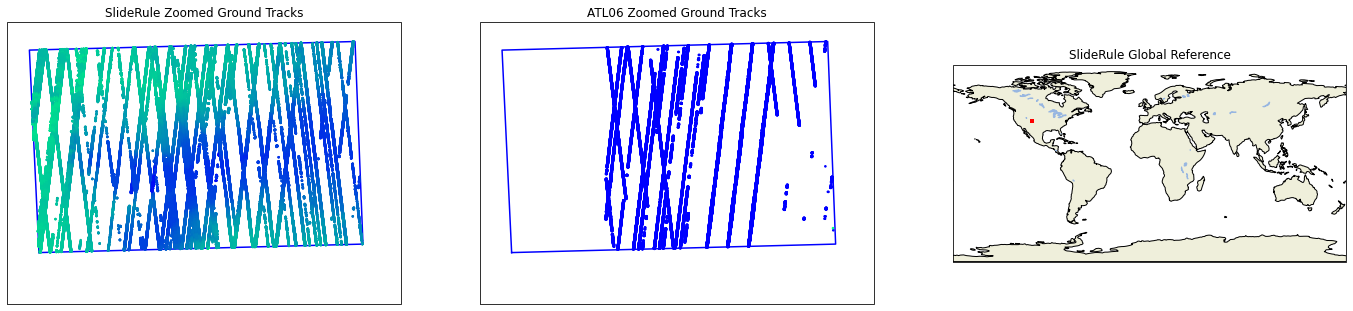

In [10]:
# Create Plot
fig = plt.figure(num=None, figsize=(24, 12))
box_lon = [e["lon"] for e in region]
box_lat = [e["lat"] for e in region]

# Plot SlideRule Ground Tracks
ax1 = plt.subplot(131,projection=cartopy.crs.PlateCarree())
ax1.set_title("SlideRule Zoomed Ground Tracks")
ax1.scatter(df["lon"].values, df["lat"].values, s=2.5, c=df["h_mean"], cmap='winter_r', zorder=3, transform=cartopy.crs.PlateCarree())
ax1.set_extent((-108.4,-107.7,38.8,39.3),crs=cartopy.crs.PlateCarree())
ax1.plot(box_lon, box_lat, linewidth=1.5, color='b', zorder=2, transform=cartopy.crs.Geodetic())

# Plot ATL06 Ground Tracks
ax2 = plt.subplot(132,projection=cartopy.crs.PlateCarree())
ax2.set_title("ATL06 Zoomed Ground Tracks")
ax2.scatter(atl06p["longitude"], atl06p["latitude"], s=2.5, c=atl06p["h_li"], cmap='winter_r', zorder=3, transform=cartopy.crs.PlateCarree())
ax2.set_extent((-108.4,-107.7,38.8,39.3),crs=cartopy.crs.PlateCarree())
ax2.plot(box_lon, box_lat, linewidth=1.5, color='b', zorder=2, transform=cartopy.crs.Geodetic())

# Plot SlideRule Global View
ax3 = plt.subplot(133,projection=cartopy.crs.PlateCarree())
ax3.set_title("SlideRule Global Reference")
ax3.scatter(df["lon"].values, df["lat"].values, s=2.5, color='r', zorder=3, transform=cartopy.crs.PlateCarree())
ax3.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
ax3.add_feature(cartopy.feature.LAKES)
ax3.set_extent((-180,180,-90,90),crs=cartopy.crs.PlateCarree())

# Show Plot
plt.show()